# ECE 535/435 Lab 4: MMSE Estimation and Least Squares

### Import Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time


%matplotlib inline

In [2]:
# Functions for packing and unpacking images. 
# These are provided.

def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

### Load Data

For the training data, the first 1000 columns are the digit of 0, the next 1000 columns are the digit of 1, and so on, up to digit 9. For the testing data, the first 100 columns are the digit of 0, the next 100 columns are the digit of 1, and so on, up to digit 9.

In [3]:
# Load MNIST train and test data
# Normalize image pixels to [0,1]

train = np.load('MNISTcwtrain1000.npy').astype(float)/255
test = np.load('MNISTcwtest100.npy').astype(float)/255

size = train.shape[0]
n_train = train.shape[1]
n_test = test.shape[1]

print('-----MNIST Dataset Loaded-----')
print('Train Data: %d x %d' %(size,n_train))
print('Test Data: %d x %d' %(size,n_test))

-----MNIST Dataset Loaded-----
Train Data: 784 x 10000
Test Data: 784 x 1000


In [4]:
# This function will return the indices of the pixels in 
# a centered square of side length: d = 2, 4, 6, 8,..., 12, 14. 
# It is provided.

def return_mask_idx(sl):
    s = 14-sl//2   
    idx = []
    for i in range(sl):
        for j in range(sl):
            idx.append(28*(s+i)+s+j) 
    return idx

### 1. Mask Center Square of MNIST Digits
a) Implement a function to fill an dxd square in the image center with black.  
b) Using $d = 12$, display the original image and the corresponding masked image, in a 1 by 2 array, for the first example in each class of the testing data. 
c) Now use the training data to estimate the MMSE affine estimator $(W, b)$ of the masked pixel values based on the unmasked pixel values. Write this so that you can use any vlaue of $d$.  
d) Now modify you code for part b) to display the original image, the corresponding masked image, and the estimated image in a 1 by 3 array, for the first example in each class of the testing data. 

In [5]:
#This function is provided

def hide(img_vector, mask_idx):
    img_vector_copy = np.copy(img_vector)
    img_vector_copy[mask_idx] = 0
    return img_vector_copy

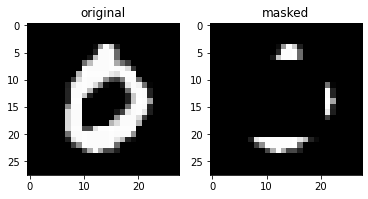

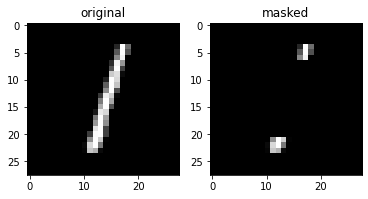

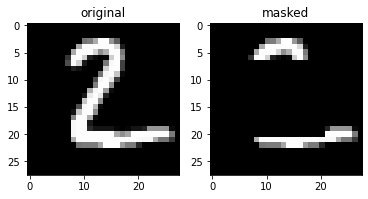

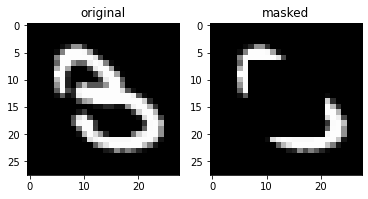

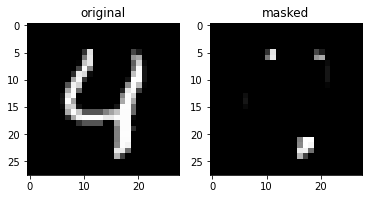

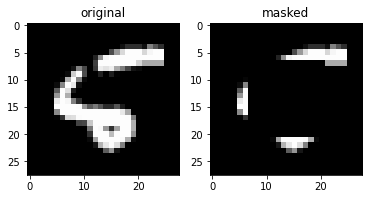

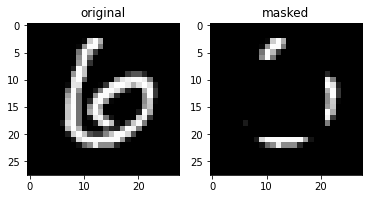

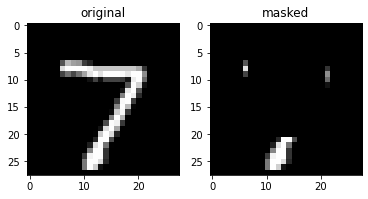

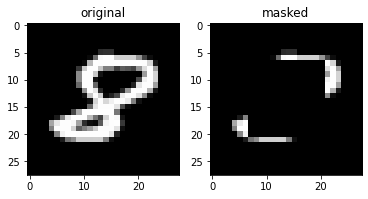

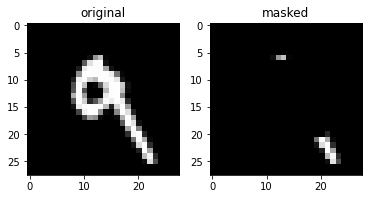

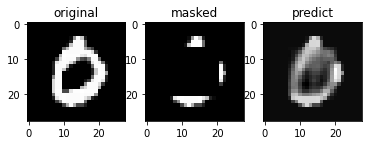

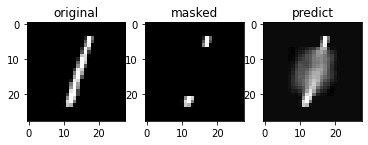

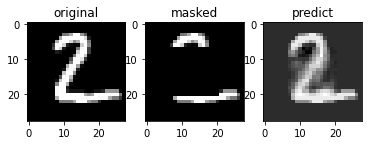

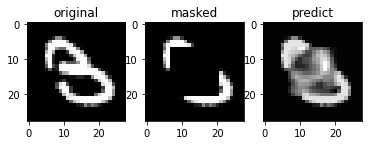

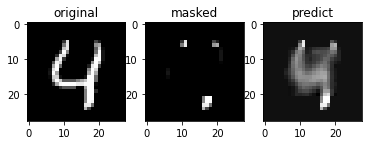

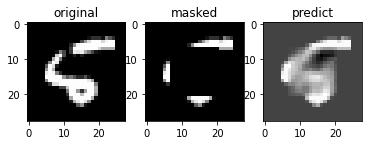

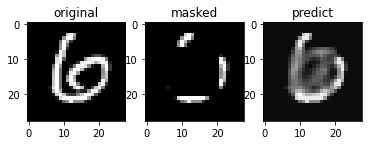

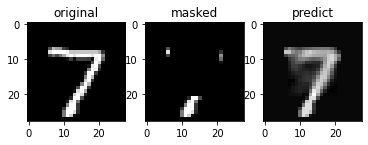

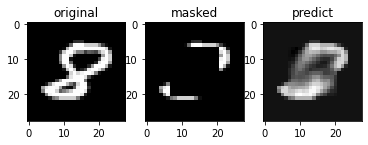

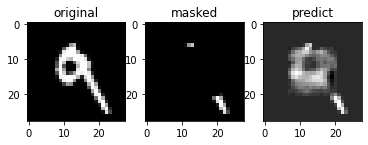

In [6]:
# Display original, masked, and estimated testing images 
# This code is given to you:

train_class_samples = 1000
test_class_samples = 100
classes = 10

dd = 14
hidden_idx = return_mask_idx(dd)
remain_idx = np.delete(np.arange(0, 784), hidden_idx)

def black_center(images, dimension):
    mask_idx = return_mask_idx(dimension)
    black_center_images = np.copy(images)
    black_center_images[mask_idx, :] = 0
    return black_center_images

train_black_center = black_center(train, dd)
test_black_center = black_center(test, dd)

test_1st = test[0:-1:test_class_samples, :]
test_black_center_1st = test_black_center[0:-1:test_class_samples, :]

for i in range(classes):
    img = test[:, i * test_class_samples]
    img_black_center = hide(img, hidden_idx)
    
    plt.figure()
    plt.subplot(1, 2, 1)

    plt.title('original')
    plt.imshow(unpackcw(img, 28, 28), plt.cm.gray)
    
    plt.subplot(1, 2, 2)

    plt.title('masked')
    plt.imshow(unpackcw(img_black_center, 28, 28), plt.cm.gray)

    plt.show()

#----------------------------------------------------------------
# Compute W and b using the training data
# delete the rows of training data corresponding to masked pixels

def prediction(blocked_d):
    hidden_idx = return_mask_idx(blocked_d)
    remain_idx = np.delete(np.arange(0, 784), hidden_idx)
    
    train_remain = train[remain_idx, :]
    test_remain = test[remain_idx, :]
    train_hidden = train[hidden_idx, :]
    test_hidden = test[hidden_idx, :]

    train_remain_affine = np.vstack((train_remain, np.ones((1, train_remain.shape[1]))))
    test_remain_affine = np.vstack((test_remain, np.ones((1, test_remain.shape[1]))))

    train_remain_autocorrelation = train_remain_affine @ train_remain_affine.T
    eps = 0
    W = np.linalg.pinv(
        train_remain_autocorrelation + eps * np.eye(train_remain_autocorrelation.shape[0])
    ) @ train_remain_affine @ train_hidden.T
    
    train_hidden_predict = (train_remain_affine.T @ W).T
    train_predict = np.copy(train)
    train_predict[hidden_idx, :] = train_hidden_predict

    test_hidden_predict = (test_remain_affine.T @ W).T
    test_predict = np.copy(test)
    test_predict[hidden_idx, :] = test_hidden_predict
    
    return train_predict, test_predict

_, test_predict = prediction(dd)

#----------------------------------------------------------------
# Loop over all classes 0,...,9

# Get the first test example in each class
   
for i in range(classes):
    img = test[:, i * test_class_samples]
    img_black_center = hide(img, hidden_idx)
    
    plt.figure()
    plt.subplot(1, 3, 1)

    plt.title('original')
    plt.imshow(unpackcw(img, 28, 28), plt.cm.gray)
    
    plt.subplot(1, 3, 2)

    plt.title('masked')
    plt.imshow(unpackcw(img_black_center, 28, 28), plt.cm.gray)
    
    plt.subplot(1, 3, 3)

    plt.title('predict')
    plt.imshow(unpackcw(test_predict[:, i * test_class_samples], 28, 28), plt.cm.gray)

    plt.show()

### 2. Classify the Images using the nearest mean classifier.

The nearest mean classifier uses the image labels (0,...,9) to compute the mean image of each class ($\mu_0$, $\mu_1$, ...,$\mu_9$). Then classifies a new example to be the label of the nearest class mean.  
$$ \hat y (x) = \arg\min_{i\in [0,9]} \|x- \mu_i\|^2 $$  

(a) Compute the class means using the unmasked training images.   
(b) Classify the training images using the nearest mean classifer. Record the accuracy.  
(c) Classify the testing images using the nearest mean classifer. Record the accuracy. 
(d) For $d=2,..., 14$ classify the masked training images and the masked testing images using the nearest mean classifer.  
(e) Plot the classification error as a function of $d$. On the plot also indicate the classification error for the unmasked images and chance accuracy. Use a legend to distinguish the lines.

Training accuracy (distance including masked):  [(0, 0.8038), (2, 0.8049), (4, 0.7828), (6, 0.723), (8, 0.6393), (10, 0.5324), (12, 0.3812), (14, 0.2413)]
Training accuracy (distance exclusing masked):  [(0, 0.8038), (2, 0.8), (4, 0.7841), (6, 0.7595), (8, 0.722), (10, 0.6786), (12, 0.6425), (14, 0.6048)]
Testing accuracy (distance including masked):  [(0.767,), (0.775,), (0.755,), (0.706,), (0.632,), (0.522,), (0.34,), (0.221,)]
Testing accuracy (distance excluding masked):  [(0.767,), (0.765,), (0.739,), (0.709,), (0.687,), (0.65,), (0.592,), (0.547,)]


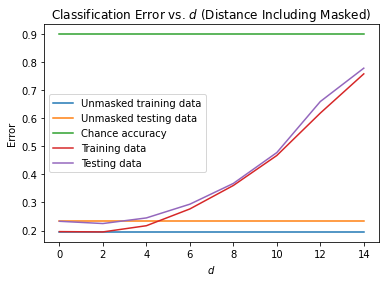

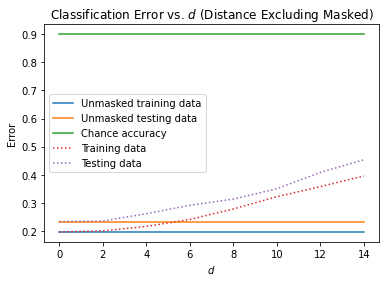

In [7]:
# Use the training data to compute the class means

train_classed = train.reshape((train.shape[0], classes, train_class_samples)).transpose((1, 0, 2))
train_classed_mean_row = train_classed.mean(axis=2)
train_classed_mean = train_classed_mean_row.reshape(classes, train.shape[0], 1)

# plt.figure()
# for i in range(classes):
#     img = train_classed_mean[i, :, 0]
#     plt.subplot(1, 10, i + 1)
#     plt.title('mean')
#     plt.imshow(unpackcw(img, 28, 28), plt.cm.gray)
# plt.show()

        
# Define nearest mean classifier

def classify(class_mean, img_vector):
    errors = class_mean - img_vector
    errors = errors.reshape(errors.shape[:2])
    error_norms = np.linalg.norm(errors, axis=1)
    return np.argmin(error_norms)

def classification_comparison(class_mean, imgs):
    classification = np.array([classify(class_mean, imgs[:, i]) for i in range(imgs.shape[1])])
    classification_comparison = (
        classification.reshape(classes, imgs.shape[1] // classes) ==
        np.array([np.arange(classes)]).T
    )
    return classification_comparison

# First: Classify the training data

accuracy_train = classification_comparison(train_classed_mean_row, train)

# Second: classify the testing data

accuracy_test = classification_comparison(train_classed_mean_row, test)

# Third: Classify the masked training data vs d

d_array = np.arange(0, 16, 2)
accuracy_train_d = [
    classification_comparison(train_classed_mean_row, black_center(train, d)).mean() for d in d_array
]
accuracy_train_fair_d = [
    classification_comparison(
        black_center(train_classed_mean_row.T, d).T, black_center(train, d)
    ).mean() for d in d_array
]

print("Training accuracy (distance including masked): ", list(zip(d_array, accuracy_train_d)))
print("Training accuracy (distance exclusing masked): ", list(zip(d_array, accuracy_train_fair_d)))

# Fourth: Classify the corrupted testing data vs d

accuracy_test_d = [
    classification_comparison(train_classed_mean_row, black_center(test, d)).mean() for d in d_array
]
accuracy_test_fair_d = [
    classification_comparison(
        black_center(train_classed_mean_row.T, d).T, black_center(test, d)
    ).mean() for d in d_array
]

print("Testing accuracy (distance including masked): ", list(zip(accuracy_test_d)))
print("Testing accuracy (distance excluding masked): ", list(zip(accuracy_test_fair_d)))

accuracy_unmasked_train = 0 * d_array + accuracy_train_d[0]
accuracy_unmasked_test = 0 * d_array + accuracy_test_d[0]
accuracy_chance = 0 * d_array + 1 / classes

plt.figure()

plt.title('Classification Error vs. $d$ (Distance Including Masked)')
plt.plot(d_array, 1 - accuracy_unmasked_train, label="Unmasked training data")
plt.plot(d_array, 1 - accuracy_unmasked_test, label="Unmasked testing data")
plt.plot(d_array, 1 - accuracy_chance, label="Chance accuracy")
plt.plot(d_array, 1 - np.array(accuracy_train_d), label="Training data")
plt.plot(d_array, 1 - np.array(accuracy_test_d), label="Testing data")
plt.legend()
plt.xlabel("$d$")
plt.ylabel("Error")

plt.show()

plt.figure()

plt.title('Classification Error vs. $d$ (Distance Excluding Masked)')
plt.plot(d_array, 1 - accuracy_unmasked_train, label="Unmasked training data")
plt.plot(d_array, 1 - accuracy_unmasked_test, label="Unmasked testing data")
plt.plot(d_array, 1 - accuracy_chance, label="Chance accuracy")
plt.plot(d_array, 1 - np.array(accuracy_train_fair_d), ':', label="Training data")
plt.plot(d_array, 1 - np.array(accuracy_test_fair_d), ':', label="Testing data")
plt.legend()
plt.xlabel("$d$")
plt.ylabel("Error")

plt.show()
    

### 3. Use least squares to approximate the masked pixels (estimation of the hidden part of the image)
Calculate the MSE for each example by constructing the following affine MSE estimator.

\begin{equation}
\arg \min_{W\in\mathbb{R}^{d^2 x(784-d^2)}}\|y-Wx-b\|_2^2
\end{equation}
\begin{equation}
y \in \mathbb{R}^{d^2}  \hspace{5mm} b \in \mathbb{R}^{d^2} \hspace{5mm} X \in \mathbb{R}^{(784-d^2)}
\end{equation}

Here $y$ is the vector of masked pixel valaues and $x$ is the remainder of the pixel values. 

Then use thr NM classifier to classify each reconstructed test image and each reconstructed traing image.
Plot the accuracies in each on a copy of the previous plot.

In [8]:
# Predict of missing pixels on testing data then classify

accuracy_test_predict_d = [
    classification_comparison(train_classed_mean_row, prediction(d)[1]).mean() for d in d_array
]
print("Testing accuracy with prediction (distance including masked): ", list(zip(d_array, accuracy_test_predict_d)))

Testing accuracy with prediction (distance including masked):  [(0, 0.767), (2, 0.767), (4, 0.754), (6, 0.726), (8, 0.702), (10, 0.682), (12, 0.645), (14, 0.607)]


In [9]:
# Predict of missing pixels on training data then classify

accuracy_train_predict_d = [
    classification_comparison(train_classed_mean_row, prediction(d)[0]).mean() for d in d_array
]
print("Training accuracy with prediction (distance including masked): ", list(zip(d_array, accuracy_train_predict_d)))

Training accuracy with prediction (distance including masked):  [(0, 0.8038), (2, 0.8025), (4, 0.7941), (6, 0.7816), (8, 0.7563), (10, 0.7296), (12, 0.7012), (14, 0.6702)]


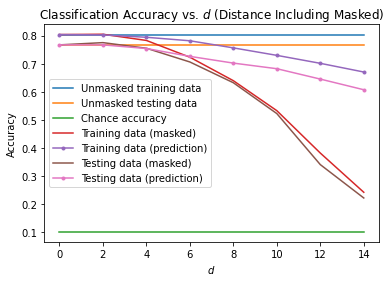

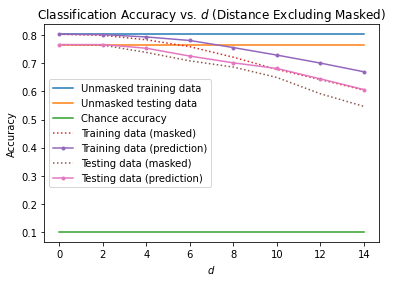

In [10]:
# Plot performance of all 

plt.figure()

plt.title('Classification Accuracy vs. $d$ (Distance Including Masked)')
plt.plot(d_array, accuracy_unmasked_train, label="Unmasked training data")
plt.plot(d_array, accuracy_unmasked_test, label="Unmasked testing data")
plt.plot(d_array, accuracy_chance, label="Chance accuracy")
plt.plot(d_array, accuracy_train_d, label="Training data (masked)")
plt.plot(d_array, accuracy_train_predict_d, '.-', label="Training data (prediction)")
plt.plot(d_array, accuracy_test_d, label="Testing data (masked)")
plt.plot(d_array, accuracy_test_predict_d, '.-', label="Testing data (prediction)")
plt.legend()
plt.xlabel("$d$")
plt.ylabel("Accuracy")
    
plt.show()

plt.figure()

plt.title('Classification Accuracy vs. $d$ (Distance Excluding Masked)')
plt.plot(d_array, accuracy_unmasked_train, label="Unmasked training data")
plt.plot(d_array, accuracy_unmasked_test, label="Unmasked testing data")
plt.plot(d_array, accuracy_chance, label="Chance accuracy")
plt.plot(d_array, accuracy_train_fair_d, ':', label="Training data (masked)")
plt.plot(d_array, accuracy_train_predict_d, '.-', label="Training data (prediction)")
plt.plot(d_array, accuracy_test_fair_d, ':', label="Testing data (masked)")
plt.plot(d_array, accuracy_test_predict_d, '.-', label="Testing data (prediction)")
plt.legend()
plt.xlabel("$d$")
plt.ylabel("Accuracy")
    
plt.show()